In [1]:
import cv2
import os.path
from utils.parser import AnnotationParser
import numpy as np
import albumentations as A
from utils.visualize  import *
from transforms import RandomExpand
from dataset import VOCDataset
from dataloader import od_collate_fn
import torch.utils.data as data
from trainer import Trainer
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from model import SSD
from losses import MultiBoxLoss
from trainer import Trainer


c:\Users\msfmh\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\msfmh\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# configuration for data
root_dir = r'C:\Users\msfmh\OneDrive\ドキュメント\Machine Learning\ssd\data\VOCdevkit\VOC2012'
anno_dir = r'C:\Users\msfmh\OneDrive\ドキュメント\Machine Learning\ssd\data\VOCdevkit\VOC2012\Annotations'
img_dir = r'C:\Users\msfmh\OneDrive\ドキュメント\Machine Learning\ssd\data\VOCdevkit\VOC2012\JPEGImages'

id = '2007_000039'
img_path = os.path.join(img_dir, (id + '.jpg'))
anno_path = os.path.join(anno_dir, id + '.xml')


img = cv2.cvtColor(cv2.imdecode(np.fromfile(img_path), flags=cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

In [3]:
anno_parser = AnnotationParser()
names, bboxes, difficults, poses = anno_parser(anno_path)

In [4]:
# transform
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=30),
    #A.SmallestMaxSize(max_size=300),
    RandomExpand(0),
    #A.SmallestMaxSize(max_size=300),
    #A.RandomCrop(width=300, height=300),
    A.Resize(300,300),
    #A.RandomSizedCrop(min_max_height=(30, 300), height=300, width=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

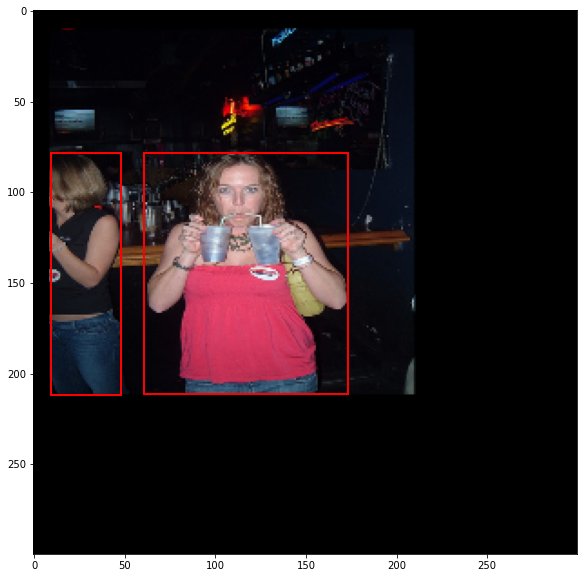

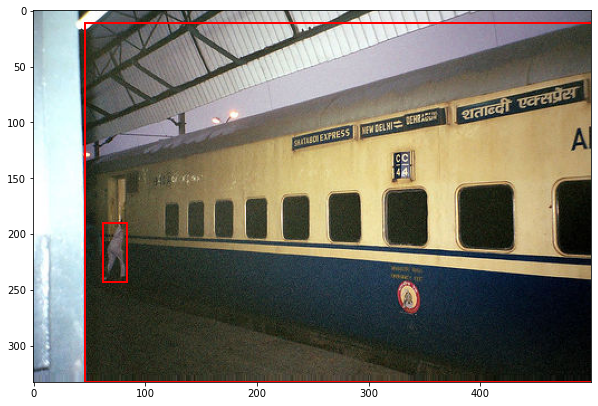

In [5]:
#datasets
train_set = VOCDataset(dir=root_dir, anno_parser=anno_parser, train=True, transform=transform)
val_set = VOCDataset(dir=root_dir, anno_parser=anno_parser, train=False, transform=None)

train_img01, train_bboxes, train_labels = train_set[101]
val_img01, val_boxes, val_labels = val_set[1]

visualize(train_img01, train_bboxes)
visualize(val_img01, val_boxes)

In [6]:
# dataloader
train_loader = data.DataLoader(dataset=train_set, batch_size=30, shuffle=True, collate_fn=od_collate_fn)
val_loader = data.DataLoader(dataset=val_set, batch_size=30, shuffle=True, collate_fn=od_collate_fn)
dataloader_dict = {'train': train_loader, 'val': val_loader}

In [7]:
# model
model = SSD()
# vgg_weights = torch.load(r'C:\Users\msfmh\OneDrive\ドキュメント\Machine Learning\ssd\weights/vgg16_reducedfc.pth')
# model.vgg.load_state_dict(vgg_weights)

In [8]:
# initialize parameters
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
model.extras.apply(weights_init)
model.location.apply(weights_init)
model.confidence.apply(weights_init)

Confidence(
  (conv1): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [9]:
# 訓練デバイス設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('使用デバイス: ', device)

使用デバイス:  cpu


In [10]:
loss_fn = MultiBoxLoss()

In [11]:
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

In [12]:
trainer = Trainer(model, dataloader_dict=dataloader_dict, loss_fn=loss_fn, optimizer=optimizer, max_epochs=2)

In [14]:
trainer.train()

使用デバイス:  cpu
----------------------
Epoch 1/2
----------------------
 (train) 
